<a href="https://colab.research.google.com/github/Huyvubk/Math/blob/main/Background_substraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Viết chương trình sử dụng kỹ thuật background substraction để trích xuất forgeground (object mong muốn) và dán vào background mới. 

- Input: 3 ảnh **Background 1**, **Background 2**, **Observed image**

- Output: là ảnh mới khi trích xuất object từ **Observed image** và dán vào **Background 2**

- **Gợi Ý:**
    - Đưa cả 3 ảnh về cùng kích thước
    - Dùng background substraction với**Observed image** và **Background 1** để lấy mask object (object ở đây là người MC mặc áo đỏ)
    - Mask object là ảnh binary (Foreground Mask) sẽ gồm 2 giá trị 0 là background, = 1 các vùng pixel chứa object.
    - Tạo ra ảnh output (New image) vị trí pixel nào = 1 thì lấy giá trị của **Observed image** và vị trí nào = 0 thì lấy giá trị của **Background 2**

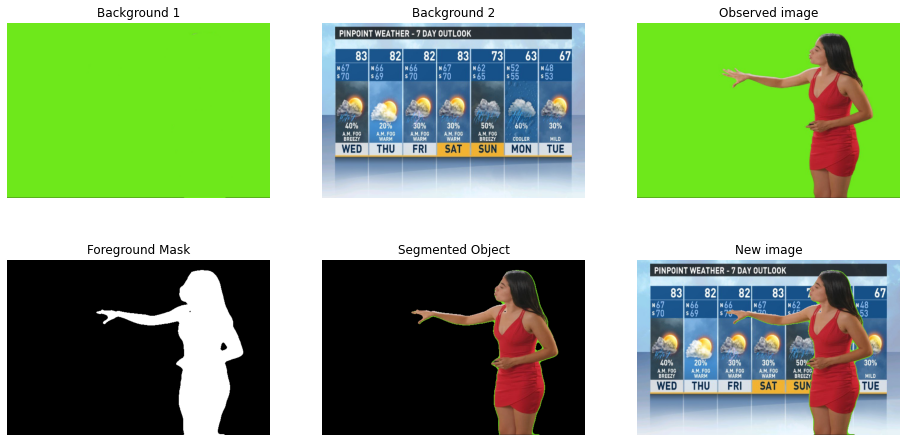

- **Step1:** Xử lý ảnh, đưa các ảnh input về cùng một size, convert sang ảnh gray và chỉ dùng Gaussian blur để giảm nhiễu cho ảnh chứa object 
- **Step2:** Tính toán absolute sự khác biệt giữa ảnh có object và **background 1** để lấy được vùng object (thường sẽ có giá trị khác biệt lớn hơn vùng background). Khi gía trị khác biệt này > ngưỡng (xác định trước) được coi là vùng có object ngược lại là background. Đưa về ảnh binary giá trị 0 là background, giá trị 1 là object.
- **Step3:** Ảnh mask là binary chỉ có 1 channel, trong khi ảnh obejct và ảnh **background 2** là ảnh màu có 3 channel. Tạo ảnh mask3dim = cách chồng 3 ảnh mask lên nhau. 
- **Step4:** Vị trí nào trên mask có giá trị = 1 thì thay bằng gía trị có vị trí tường ứng trong ảnh object. Ngược lại, thay giá trị trong **background 2**.

In [1]:
!gdown --id '1eo6HTPO4Rg7EfvAWZdj3sSqavozjO7U3'
!gdown --id "1RtDrlcEi4b9zQdMtERE8xIDXiM25Gqwj"
!gdown --id "1XXDJGHy_urljg400UhhKHeKIyvoACv5f"

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1eo6HTPO4Rg7EfvAWZdj3sSqavozjO7U3
To: /content/weather_forecast.jpg
100% 83.3k/83.3k [00:00<00:00, 60.1MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RtDrlcEi4b9zQdMtERE8xIDXiM25Gqwj
To: /content/background4.png
100% 6.89k/6.89k [00:00<00:00, 14.4MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.goo

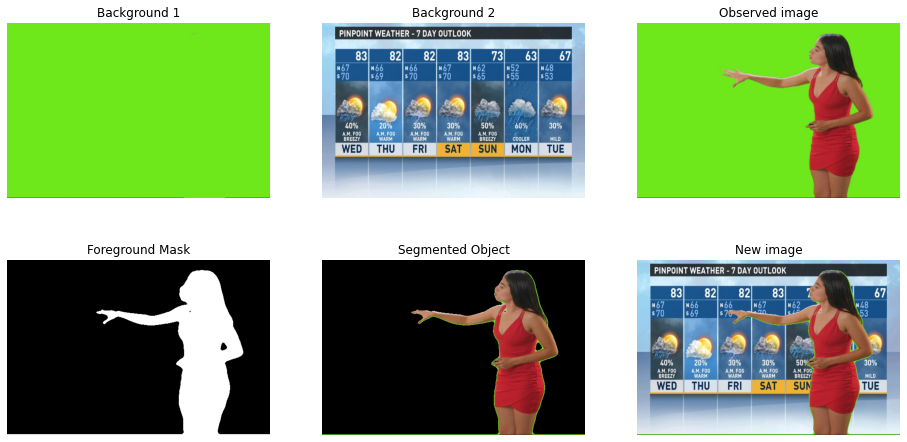

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

bg_path = '/content/background4.png'
new_bg_path = '/content/weather_forecast.jpg'
obs_path = '/content/pg4.png'

def preprocessing_image(image_path, denoising=True, img_size=(600, 400)):
    image = cv2.imread(image_path)
    # Cần phải resize các ảnh cùng 1 kích thước
    rez_image = cv2.resize(image, img_size)
    gray_image = cv2.cvtColor(rez_image, cv2.COLOR_BGR2GRAY)
    # Sử dụng gaussian blur để hạn chế nhiễu
    if denoising:
        gray_image = cv2.GaussianBlur(gray_image, (5,5), 0)
    return rez_image, gray_image

def gray_diff(bg_path, obs_path, new_bg_path, img_size=(600, 400)):
    # Preprocessing image
    bg_img, gray_bg_img = preprocessing_image(bg_path, denoising=False, img_size=img_size)
    obs_img, gray_obs_img = preprocessing_image(obs_path, denoising=True, img_size=img_size)
    new_bg_img, gray_new_bg = preprocessing_image(new_bg_path, denoising=False, img_size=img_size)
    
    # Tính absolute khác biệt giữa ảnh có obejct và background 1
    difference = cv2.absdiff(gray_bg_img, gray_obs_img)
    
    # Tạo ảnh binary giá trị < 10 sẽ được assign = 0, và giá trị > 10 sẽ được assign = 255
    _, mask = cv2.threshold(difference, thresh=10, maxval=255, type=cv2.THRESH_BINARY)
    
    # Dùng median blur giảm nhiễu 
    mask = cv2.medianBlur(mask, 9)

    # Tạo ảnh mask 3 channels để dùng cho ảnh color hiện tại có 3 channels (B, G, R)
    # đưa về 2 giá trị 0: background, 1: forgeground
    mask_3dims = np.expand_dims(np.where(mask > 0, 1, 0), axis=2) * np.ones((img_size[1], img_size[0], 3), dtype=np.uint8)
    
    # Giúp lấy ảnh object (phục vụ debug)
    seg_obj = mask_3dims * obs_img

    # Dùng mask 3 channels này để dán obejct vào background mới 
    masked_img = np.where(mask_3dims==0, new_bg_img, obs_img )

    return bg_img, new_bg_img, obs_img, mask_3dims*255, seg_obj, masked_img
    # return gray_bg_img, gray_obs_img, gray_new_bg, mask_3dims*255, seg_obj, masked_img


# bg_img, obs_img, new_bg_img, mask_3dims, seg_obj, masked_img 
results = gray_diff(bg_path, obs_path, new_bg_path, img_size=(600, 400))

fig = plt.figure(figsize=(16,8))
name_list = ['Background 1', 'Background 2', 'Observed image', 'Foreground Mask', 'Segmented Object', 'New image']
for idx, img in enumerate(results):
    fig.add_subplot(2,3,idx+1)
    plt.title(name_list[idx])
    plt.axis('off')
    plt.imshow(results[idx][..., ::-1])
    cv2.imwrite(name_list[idx]+'.jpg', results[idx])

plt.show()
